# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


In [1]:
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

---

## exponentially autocorrelated low-frequency velocity signal


In [2]:
u_low = sg.low_frequency_signal()

# note we also could consider / add a high frequency component
# u_high = sg.high_frequency_signal()

- U = signal amplitude (standard deviation)
- $T$ = signal decorrelation time scale (exponential autocorrelation)

In [3]:
T, U = u_low.p["T"], u_low.p["U"]
# sigma = u_high.p['sigma']
omega, tau = u_low.omega, u_low.tau

# print analytical spectrum
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

Such spectrum leads to a flat acceleration spectrum at high frequencies which cannot be integrated and suggests acceleration is white noise.

#### Illustration

In [4]:
# decorrelation timescales
T = [5,10,20,40]
t = (1000, 1 / 24) # timeline: 1000 days with hourly sampling
N = 10 # number of random draws

In [6]:
# generate velocity first
da = u_low.generate_tseries(
    params=dict(T=T),
    draws=N,
    time=t,
    seed=0,
)

# derive position and acceleration
ds = da.rename("u").assign_attrs(units="m/s").to_dataset().persist()
ds["time"] = ds["time"].assign_attrs(units="days")
ds["x"] = ds["u"].cumulative_integrate("time") #.assign_attrs(units="m")
ds["a"] = ds["u"].differentiate("time").assign_attrs(units="m/s^2") /86400  # rescale in m/s
ds = ds.persist()

# compute autocorrelations
xx = sigp.correlate(ds.x, ds.x).rename("xx").persist()
uu = sigp.correlate(ds.u, ds.u).rename("uu").persist()
aa = sigp.correlate(ds.a, ds.a).rename("aa").persist()
dsc = xr.merge([xx, uu, aa])

# compute spectra
Ex, omega = sigp.spectrum_welch(ds.x, T=100)
Eu, omega = sigp.spectrum_welch(ds.u, T=100)
Ea, omega = sigp.spectrum_welch(ds.a, T=100)
dsE = xr.merge([Ex, Eu, Ea])
dsE = dsE.rename({i : 'E'+i for i in list(dsE.keys())})

ds_exp = xr.merge([ds, dsc, dsE])

In [7]:
ds_exp

<xarray.Dataset>
Dimensions:    (T: 4, time: 24000, draw: 10, lags: 24000, freq_time: 2400)
Coordinates:
  * T          (T) int64 5 10 20 40
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
Data variables:
    u          (T, time, draw) float64 dask.array<chunksize=(4, 24000, 10), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 1, 10), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 24000, 10), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>

In [8]:

ds_exp0 = ds_exp.chunk({'T':4,'time' : 5000, 'draw':-1, 'lags':5000})

In [9]:
ds_exp0

<xarray.Dataset>
Dimensions:    (T: 4, time: 24000, draw: 10, lags: 24000, freq_time: 2400)
Coordinates:
  * T          (T) int64 5 10 20 40
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
Data variables:
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>

In [10]:
root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
path = os.path.join(root_dir, "synthetic_traj_exp.zarr")
ds_exp0.to_zarr(path, mode="w")

In [15]:
dsl = xr.open_zarr(path, decode_timedelta=False)
dsl

<xarray.Dataset>
Dimensions:    (T: 4, draw: 10, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>

In [14]:
xr.open_zarr?

Signature:
xr.open_zarr(
    store,
    group=None,
    synchronizer=None,
    chunks='auto',
    decode_cf=True,
    mask_and_scale=True,
    decode_times=True,
    concat_characters=True,
    decode_coords=True,
    drop_variables=None,
    consolidated=None,
    overwrite_encoded_chunks=False,
    chunk_store=None,
    storage_options=None,
    decode_timedelta=None,
    use_cftime=None,
    **kwargs,
)
Docstring:
Load and decode a dataset from a Zarr store.

The `store` object should be a valid store for a Zarr group. `store`
variables must contain dimension metadata encoded in the
`_ARRAY_DIMENSIONS` attribute or must have NCZarr format.

Parameters
----------
store : MutableMapping or str
    A MutableMapping where a Zarr Group has been stored or a path to a
    directory in file system where a Zarr DirectoryStore has been stored.
synchronizer : object, optional
    Array synchronizer provided to zarr
group : str, optional
    Group path. (a.k.a. `path` in zarr terminology.)
chun

### PLOT

In [7]:
colors = get_cmap_colors(ds.T.size, cmap="plasma")
plt.rc('axes', prop_cycle=cycler(color=colors))

def plot_timeseries(ds, tmax=100):

    fig, axes = plt.subplots(3,1, figsize=(5,10), sharex=True)

    ax = axes[0]
    ds["x"].where(ds.time < tmax).plot.line(x="time", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")


    ax = axes[1]
    ds["u"].where(ds.time < tmax).plot.line(x="time", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    ax = axes[2]
    ds["a"].where(ds.time < tmax).plot.line(x="time", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")
    
    return fig, axes


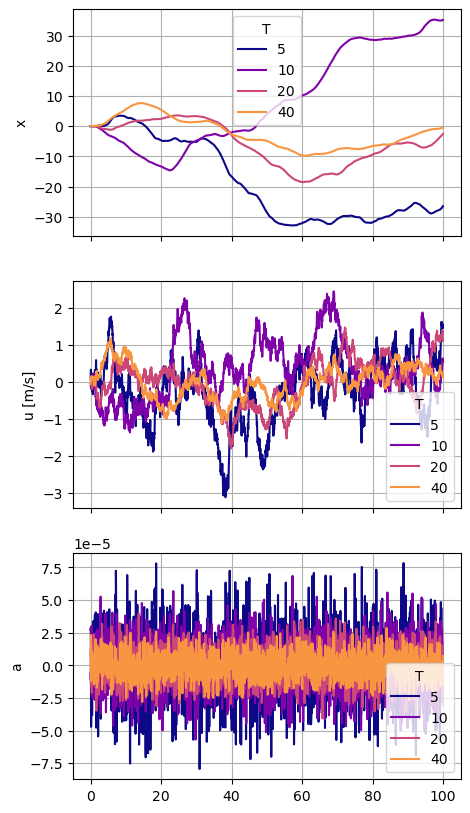

In [11]:
plot_timeseries(ds_exp.isel(draw=2));

In [14]:
def plot_autocorrelations(ds, tau_max=100):

    fig, axes = plt.subplots(3,1, figsize=(5,10), sharex=True)

    ax = axes[0]
    (ds["xx"]/ds["xx"].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")


    ax = axes[1]
    (ds["uu"]/ds["uu"].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    ax = axes[2]
    (ds["aa"]/ds["aa"].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    return fig, axes

(<Figure size 500x1000 with 3 Axes>,
 array([<AxesSubplot: ylabel='xx'>, <AxesSubplot: ylabel='uu'>,
        <AxesSubplot: ylabel='aa'>], dtype=object))

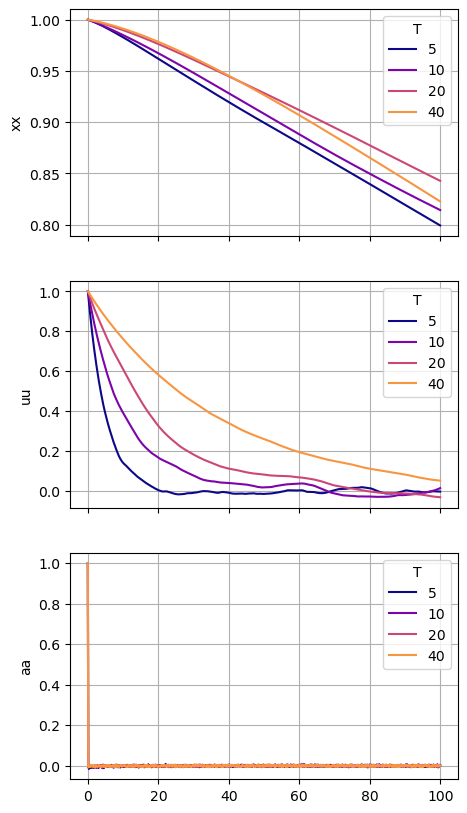

In [15]:
plot_autocorrelations(ds_exp.mean("draw"), tau_max=100)

(0.0, 1.0)

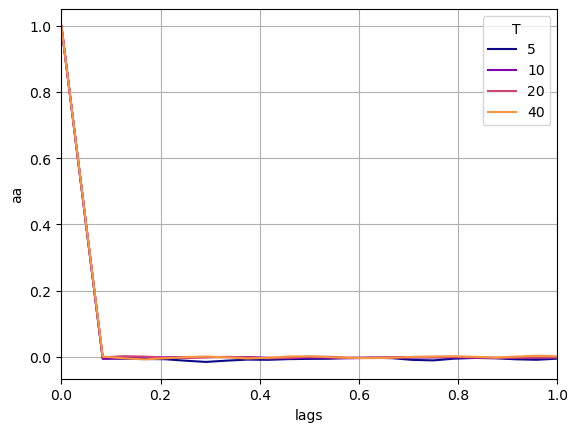

In [11]:
fig, ax = plt.subplots(1, 1)
_ = (ds["aa"] / ds["aa"].sel(lags=0)).mean("draw").plot.line(x="lags")
ax.grid()
ax.set_xlim(0, 1)

---

## Embedded OU processes: Viggiano et al. 2020

We generate timeseries corresponding to their equations (2.14-2.18).

In [16]:
tau_eta = 0.5 # short timescale
n_layers = 5 # number of layers
da = ts.spectral_viggiano(t, T, tau_eta, n_layers, draws=N).compute()

# derive position and acceleration
ds = da.rename("u").assign_attrs(units="m/s").to_dataset().persist()
ds["time"] = ds["time"].assign_attrs(units="days")
ds["x"] = ds["u"].cumulative_integrate("time") #.assign_attrs(units="m")
ds["a"] = ds["u"].differentiate("time").assign_attrs(units="m/s^2") /86400  # rescale in m/s
ds = ds.persist()

# compute autocorrelations
xx = sigp.correlate(ds.x, ds.x).rename("xx").persist()
uu = sigp.correlate(ds.u, ds.u).rename("uu").persist()
aa = sigp.correlate(ds.a, ds.a).rename("aa").persist()
dsc = xr.merge([xx, uu, aa])

# compute spectra
Ex, omega = sigp.spectrum_welch(ds.x, T=100)
Eu, omega = sigp.spectrum_welch(ds.u, T=100)
Ea, omega = sigp.spectrum_welch(ds.a, T=100)
dsE = xr.merge([Ex, Eu, Ea])
dsE = dsE.rename({i : 'E'+i for i in list(dsE.keys())})
ds_ou = xr.merge([ds, dsc, dsE])
ds_ou

<xarray.Dataset>
Dimensions:    (T: 4, time: 24000, draw: 10, lags: 24000, freq_time: 2400)
Coordinates:
  * T          (T) int64 5 10 20 40
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
Data variables:
    u          (T, time, draw) float64 2.531 -0.55 2.294 ... 1.698 -1.252 2.038
    x          (T, time, draw) float64 0.0 0.0 0.0 0.0 ... 126.0 58.33 635.9
    a          (T, time, draw) float64 1.334e-06 1.434e-06 ... -9.31e-07
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>

In [17]:
root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
path = os.path.join(root_dir, "synthetic_traj_ou.zarr")
ds_ou.chunk({'T':-1,'time' : 5000, 'draw':-1, 'lags':5000}).to_zarr(path, mode="w")

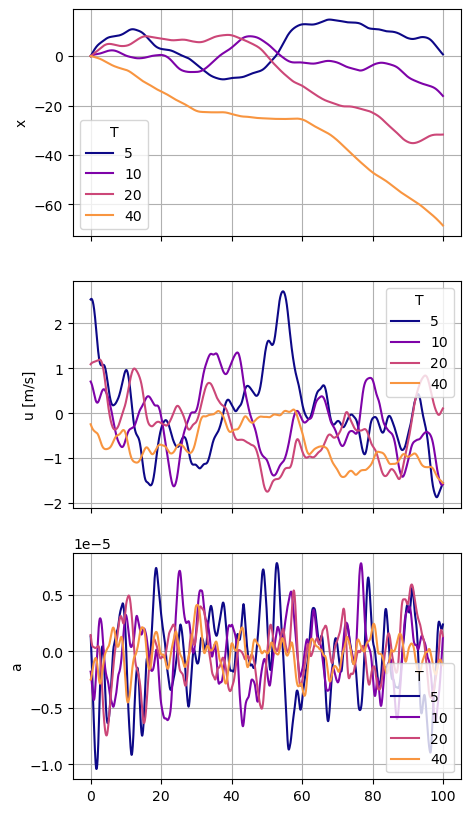

In [21]:
plot_timeseries(ds_ou.isel(draw=0));

(<Figure size 500x1000 with 3 Axes>,
 array([<AxesSubplot: ylabel='xx'>, <AxesSubplot: ylabel='uu'>,
        <AxesSubplot: ylabel='aa'>], dtype=object))

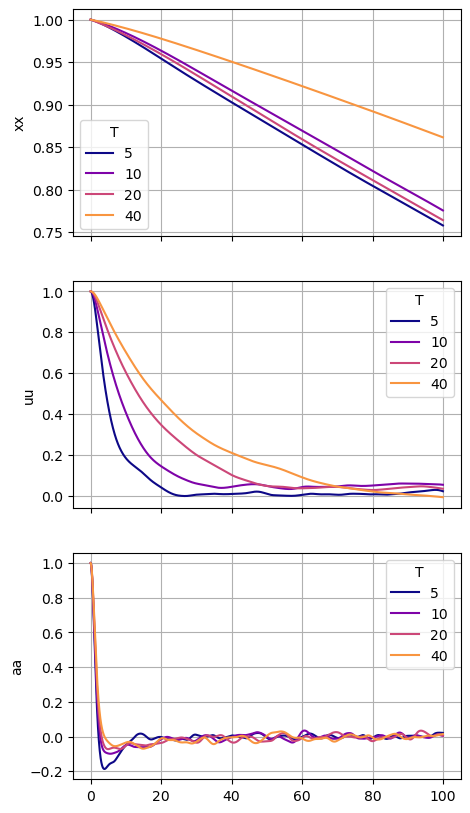

In [15]:
plot_autocorrelations(dsc.mean("draw"), tau_max=100)

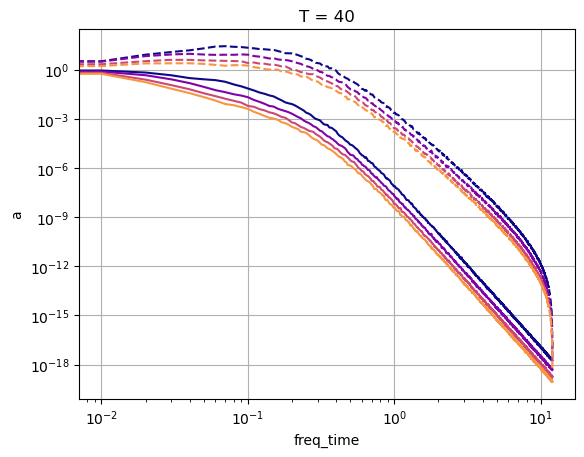

In [16]:
fig, ax = plt.subplots(1,1)

for _T, c in zip(T, colors):
    _E = Eu.mean("draw")
    (_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, label=f"T={float(_T):.0f}d")
    _E = Ea.mean("draw")
    (_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls="--")
    #Eu.mean("draw").sel(tau_eta=1).plot(x="freq_time", ax=ax, hue="T")

ax.set_xscale("log")
ax.set_yscale("log")

ax.grid()

---

## white noise

Generating white noise to add to position or velocity

In [17]:
noise_std = 1.

# first method: common noise realization 
from numpy.random import randn
ds["noise_c"] = ("time", randn(ds.time.size)*noise_std)

# second method: independent noise realizations
# scale represents the noise 
ds["noise_i"] = ts.normal(t, draws=N)*noise_std